In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import scipy as scy
import time

import pandas as pd
import zipfile

In [2]:
labFS = 16
legFS = 12

In [3]:
def ReadNetwork (path_to_zipped_file):
    '''
    INPUT
    - path_to_zipped_file: string. Self-explanatory name.
    
    OUTPUT
    - G : nx.Graph(). Graph that has been readed from a zipped file from Netzschleuder.
    '''

# open zip with network files
    with zipfile.ZipFile(path_to_zipped_file) as z:
    # open file for the edges 
        with z.open('edges.csv') as f:
            df = pd.read_csv(f)
            df = df.rename(columns={"# source": " source"})
            for col in df.columns:
                df = df.rename(columns={col: col[1:]})
        # create network from edge list (call the proper network constructor, e.g., DiGrpah if directed)
            if 'weight' in df.columns:
                # Create graph including edge weights
                G = nx.from_pandas_edgelist(df, edge_attr='weight')
                
            else:
                # Create graph without edge weights
                G = nx.from_pandas_edgelist(df)
        
        '''
    # open file for the graph properties (this one was a little tricky...)
        parsed_data = []
        with z.open('gprops.csv') as f:
            for line in f:
                decoded_line = line.decode('utf-8')
            # Skip empty lines or lines starting with '#'
                if not decoded_line.strip() or decoded_line.startswith('#'):
                    continue
        
            # Split the line by the first comma only, since only 2 fields are expected
                split_line = decoded_line.split(',', 1)
        
            # Check if the line is split into exactly 2 parts
                if len(split_line) == 2:
                # Trim and strip quotes from the second part if necessary
                    key, value = split_line
                    value = value.strip().strip('"')
                    parsed_data.append([key.strip(), value])
                    
        for prop,value in parsed_data:
            G.graph[prop] = value
        '''
        
    # open file for node properties and add them to the graph
        with z.open('nodes.csv') as f:
            df = pd.read_csv(f)
            df = df.rename(columns={"# index": " id"})
            for col in df.columns:
                df = df.rename(columns={col: col[1:]})
            for att in list(df.columns[1:]):
                att_dict = pd.Series(df[att].values,index=df.id).to_dict()
                nx.set_node_attributes(G,att_dict,att)
            
    return G

# __Dedicated to change the 'edges.csv' file to prepare it for the community detection__

In [85]:
df = pd.read_csv(r'network_10\edges.csv')
columns = list(df.columns)
sources = df[columns[0]].tolist()
targets = df[columns[1]].tolist()
tuples = [(sources[i], targets[i]) for i in range(len(sources))]

set_tuples = sorted(list(set(tuples)))
weight = np.zeros(len(set_tuples))
for i in range(len(set_tuples)):
    if set_tuples[i][0]==set_tuples[i][1]:
        weight[i] = tuples.count(set_tuples[i])
    else:
        weight[i] = tuples.count(set_tuples[i]) + tuples.count((set_tuples[i][1], set_tuples[i][0]))
        
source = [pair[0] for pair in set_tuples]
target = [pair[1] for pair in set_tuples]

data = {
    columns[0]: source,
    columns[1]: target,
    ' weight' : weight
}

df2 = pd.DataFrame(data)
df2.to_csv('edges.csv', index = False)

# __Reading the network__

Network of faculty hiring in Computer Science Departments. Each node is a PhD-granting institution in the respective field, and a directed edge (i,j) indicates that a person received their PhD from node i and was tenure-track faculty at node j during time of collection (2011-2013). All data collected from faculty public rosters at the sampled institutions.

In [4]:
G = ReadNetwork(r'network_10_edges_changed.zip')
# You don't need to do this, since when reading the graph as a nx.Graph() and not as a nx.DiGraph() the work avoiding the
# (j,i) edge when (i,j) was already taken into account is already done.
# G = G.to_undirected()

In [5]:
is_disconnected = not nx.is_connected(G)

if is_disconnected:
    num_components = nx.number_connected_components(G)
    print(f"The graph is disconnected with {num_components} connected component(s).")
else:
    print("The graph is connected.")

The graph is connected.


# __1. Structural Analysis__

a) Number of nodes, links, network density. 

b) Average clustering coefficient of the nodes (Watts-Strogatz clustering coefficient). 

c) Global clustering coefficient (Newman transitivity). 

d) Average path length and diameter of the network. 

In [6]:
# Number of nodes and edges
nodes = sorted(list(G.nodes()))
num_nodes = len(nodes)
print(num_nodes)
num_edges = len(G.edges())
print(num_edges)

# Density
rho = nx.density(G)
print(rho)

# Average clustering coefficient
C_av = nx.average_clustering(G)

# Global clustering coefficient
C_global = nx.transitivity(G)

# Average path length
av_path_len = nx.average_shortest_path_length(G)

# Diameter
D = nx.diameter(G)

# Degree for each node
k =[]
for n in nodes:
    k.append(G.degree(n))

e) Obtain a plot of the degree distribution of the network. You should plot both the PDF and
CDF. You may attempt to fit these distributions (at least the CDF) to more than one
distribution.

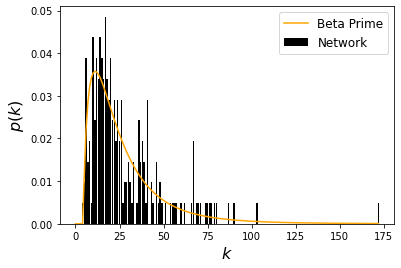

In [188]:
# This histogram gives the frequency for each possible node degree
degree_distribution = nx.degree_histogram(G)
k_pdf = degree_distribution/np.sum(degree_distribution)

# NOTA: cuando ahora calculas np.sum(degree_distribution) para normalizar, eso es el número total de nodos
degrees = range(len(pdf))
plt.bar(degrees, k_pdf, color = 'black', label = r'Network')
params = [1.7, 5.4, 4.5, 61]
plt.plot(degrees, scy.stats.betaprime.pdf(degrees,*params),color = 'orange', label = r'Beta Prime')
plt.xlabel('$k$', fontsize = labFS)
plt.ylabel('$p(k)$', fontsize = labFS)
plt.legend(fontsize = legFS)
plt.savefig('PDF.pdf', bbox_inches = 'tight')
plt.show()

In [152]:
nodes = list(G.nodes())
degrees = [G.degree(i) for i in nodes]
index = degrees.index(np.max(degrees))
nodes[index]

205

In [158]:
degrees[index] = 0
np.max(degrees)
index2 = degrees.index(103)

In [159]:
G.nodes[nodes[index2]].get('institution')

'University of Illinois, Urbana Champaign'

In [145]:
degrees

[(0, 77),
 (1, 75),
 (2, 90),
 (3, 51),
 (4, 74),
 (5, 79),
 (6, 67),
 (7, 43),
 (8, 62),
 (9, 103),
 (10, 70),
 (11, 69),
 (12, 43),
 (13, 60),
 (14, 38),
 (15, 29),
 (16, 80),
 (17, 47),
 (18, 66),
 (19, 41),
 (20, 48),
 (21, 28),
 (22, 67),
 (23, 40),
 (24, 76),
 (25, 56),
 (26, 41),
 (27, 33),
 (28, 54),
 (29, 46),
 (30, 20),
 (31, 67),
 (32, 71),
 (33, 49),
 (34, 44),
 (35, 39),
 (36, 38),
 (37, 41),
 (38, 38),
 (39, 36),
 (40, 41),
 (41, 23),
 (42, 26),
 (43, 22),
 (44, 20),
 (45, 31),
 (46, 29),
 (47, 21),
 (48, 22),
 (49, 35),
 (50, 39),
 (51, 13),
 (52, 13),
 (53, 36),
 (54, 24),
 (55, 25),
 (56, 36),
 (57, 25),
 (58, 17),
 (59, 26),
 (60, 14),
 (61, 24),
 (62, 37),
 (63, 46),
 (64, 20),
 (65, 15),
 (66, 18),
 (67, 8),
 (68, 21),
 (69, 15),
 (70, 9),
 (71, 20),
 (72, 11),
 (73, 33),
 (74, 57),
 (75, 41),
 (76, 30),
 (77, 55),
 (78, 67),
 (79, 41),
 (80, 22),
 (81, 36),
 (82, 48),
 (83, 16),
 (84, 46),
 (85, 38),
 (86, 26),
 (87, 20),
 (88, 30),
 (89, 37),
 (90, 17),
 (91, 26),

alpha
a:  9.714398050903045e-08  loc:  1.202086148520104  scale:  1.6100487655892002
[0.31389956 0.92905842 0.89156061]
R2:  0.48221055274711766
betaprime
a:  1.6967535416007122 b:  5.449176958321569  loc:  4.456449807804484  scale:  60.87506711699387
[ 0.20239608  0.67875421  0.56376864 14.52580579]
R2:  0.9983301995888778
chi2
df:  1.6827510003320747  loc:  8.13819671839441  scale:  11.487840894639806
[0.05538427 0.22666376 0.31376986]
R2:  0.9975640016948977
exponnorm
K:  7.685322020608775  loc:  6.752881921853616  scale:  2.63418719122473
[0.99277278 0.1249639  0.32996392]
R2:  0.9983465817103353


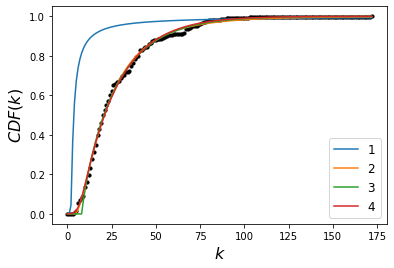

In [177]:
# Compute the cumulative distribution function (CDF)
k_cdf = np.cumsum(k_pdf)

# Normalize CDF to ensure it goes from 0 to 1
# k_cdf = k_cdf / k_cdf[-1]

plt.scatter(degrees,k_cdf, color = 'black', s = 10)

# Here fits to several probability distributions will be shown
def alpha_cdf(x, a, loc, scale):
    return scy.stats.alpha.cdf(x, a, loc, scale)

params, cov = scy.optimize.curve_fit(alpha_cdf, degrees, k_cdf)
errParam = np.sqrt(np.diag(cov))
print('alpha')
print('a: ', params[0], ' loc: ', params[1], ' scale: ', params[2])

fitted_cdf = alpha_cdf(degrees, *params)
R2 = 1 - np.var(k_cdf-fitted_cdf)/np.var(k_cdf)
print(errParam)
print('R2: ', R2)

plt.plot(degrees, fitted_cdf, label = r'$1$')


def betaprime_cdf(x, a, b, loc, scale):
    return scy.stats.betaprime.cdf(x, a, b, loc, scale)

params, cov = scy.optimize.curve_fit(betaprime_cdf, degrees, k_cdf)
errParam = np.sqrt(np.diag(cov))
print('betaprime')
print('a: ', params[0], 'b: ', params[1], ' loc: ', params[2], ' scale: ', params[3])

fitted_cdf = betaprime_cdf(degrees, *params)
R2 = 1 - np.var(k_cdf-fitted_cdf)/np.var(k_cdf)
print(errParam)
print('R2: ', R2)

plt.plot(degrees, fitted_cdf, label=r'$2$')

def chi2_cdf(x, df, loc, scale):
    return chi2.cdf(x, df, loc, scale)

params, cov = curve_fit(chi2_cdf, degrees, k_cdf)
errParam = np.sqrt(np.diag(cov))
print('chi2')
print('df: ', params[0],' loc: ', params[1], ' scale: ', params[2])

fitted_cdf = chi2_cdf(degrees, *params)
R2 = 1 - np.var(k_cdf-fitted_cdf)/np.var(k_cdf)
print(errParam)
print('R2: ', R2)

plt.plot(degrees, fitted_cdf, label=r'$3$')

def exponnorm_cdf(x, K, loc, scale):
    return exponnorm.cdf(x, K, loc, scale)

params, cov = curve_fit(exponnorm_cdf, degrees, k_cdf)
errParam = np.sqrt(np.diag(cov))
print('exponnorm')
print('K: ', params[0],' loc: ', params[1], ' scale: ', params[2])

fitted_cdf = exponnorm_cdf(degrees, *params)
R2 = 1 - np.var(k_cdf-fitted_cdf)/np.var(k_cdf)
print(errParam)
print('R2: ', R2)

plt.plot(degrees, fitted_cdf, label=r'$4$')

plt.xlabel('$k$', fontsize = labFS)
plt.ylabel('$CDF(k)$', fontsize = labFS)
plt.legend(fontsize = legFS)
#plt.xlim([70, 100])
#plt.ylim([0.9, 1])
#plt.savefig('CDF_zoom.pdf', bbox_inches = 'tight')
plt.show()

f) List the top 25 most central nodes according to each of the following centrality measures:
degree, closeness, betweenness, eigenvector, Katz index, PageRank and subgraph
centrality. Compare the rankings and draw conclusions.

In [42]:
def prepare_writing(centrality): 

    nodes_aux = np.asarray(nodes)
    cent = np.zeros(num_nodes)
    for i in range(num_nodes):
        cent[i] = centrality[nodes[i]]
    cent_aux = sorted(list(cent), reverse = True)[0:25]

    indexes = []
    for i in range(len(cent_aux)):
        indexes.append(np.where(cent == cent_aux[i])[0][0])

    nodes_cent = nodes_aux[indexes]
    cent = cent[indexes]
    
    return list(nodes_cent), list(cent)

In [72]:
# We have to prepare, first, the data to be writen
centrality = nx.degree_centrality(G)
n1, c1 = prepare_writing(centrality)

centrality = nx.closeness_centrality(G)
n2, c2 = prepare_writing(centrality)

centrality = nx.betweenness_centrality(G)
n3, c3 = prepare_writing(centrality)

centrality = nx.eigenvector_centrality(G)
n4, c4 = prepare_writing(centrality)

centrality = nx.pagerank(G)
n5, c5 = prepare_writing(centrality)

centrality = nx.subgraph_centrality(G)
n6, c6 = prepare_writing(centrality)

decimales = [3, 3, 4, 3, 4, 2]
#file.write("%.3f & %.3f & %.4f & %.3f & %.4f & %.2f \\\\\n"%(c1[i],c2[i],c3[i],c4[i],c5[i],c6[i]))

In [73]:
file_path = 'most_central_nodes.txt'
with open(file_path, "w") as file:
    # headers
    file.write("Degree & Closeness & Betweenness & Eigenvector & PageRank & Subgraph\\\\\n")
    
    # data
    for i in range(len(c1)):
        file.write("%.d & %.d & %.d & %.d & %.d & %.d \\\\\n"%(n1[i],n2[i],n3[i],n4[i],n5[i],n6[i]))
        

In [75]:
file_path = 'most_central_nodes_with_values.txt'
with open(file_path, "w") as file:
    # headers
    file.write("Node & Degree & Node & Closeness & Node & Betweenness & Node & Eigenvector & Node & PageRank & Node & Subgraph\\\\\n")
    
    # data
    for i in range(len(c1)):
        file.write("%.d & %.3f & %.d & %.3f & %.d & %.4f & %.d & %.3f & %.d & %.4f & %.d & %.2e \\\\\n"%(n1[i],c1[i],n2[i],c2[i],n3[i],c3[i],n4[i],c4[i],n5[i],c5[i],n6[i],c6[i]))
        

In [56]:
# Here the maximum number of iterations was placed at 5 times the default value and the tolerance at 10^5 times the default value.
# Since no convergence was possible, I simply decided to consider these measure of centrality unsuitable for the graph assigned.
centrality = nx.katz_centrality(G, alpha=0.1, beta=1, max_iter=5000, tol=1e-1)
centrality

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 5000 iterations')

g) Report the degree assortativity of this network.

In [76]:
degree_assortativity = nx.degree_assortativity_coefficient(G)
degree_assortativity

-0.12317639969503794

h) Measure numerically how close to bipartite this network is. For this you must calculate
the bipartivity index studied in this course.

In [80]:
from networkx.algorithms import bipartite
spectral_bipartivity = nx.algorithms.bipartite.spectral_bipartivity(G)
spectral_bipartivity

0.5000000000000182

# __2. Random Networks__ 

Generate 10 random realisations of the Erdös-Rényi and 10 random realisations of the
Barabási-Albert models with the same number of nodes and edges of the given network.
Then, report the averages and standard deviations of all the parameters previously
calculated in items b)-e), g)-h) (these average and standard deviations refer to the values
obtained for the 10 random realisations of the ER and of the BA network). In all cases
compare the results obtained for these random networks with those of the real network
you are studying.

n = number of nodes
m0 = number of edges formed to each node you will enter

If you want m edges at the end, you impose m0 = m/n, rounded

nx.barabasi_albert_graph(n,m0)

n = number of nodes
p = probability of forming edges

You cannot establish a fixed number of edges here, but you can fix a probability that will roughly recreate the desired number of edges.

p = 2m/n(n-1)

nx.erdos_renyi_graph(n,p)

In [28]:
N = 10
n = len(G.nodes)
m = len(G.edges)
m0 = round(m/n)

C_av = np.zeros(N)
C_global = np.zeros(N)
av_path_len = np.zeros(N)
D = np.zeros(N)
mean_degree = np.zeros(N)
degree_assortativity = np.zeros(N)
spectral_bipartivity = np.zeros(N)

for i in range(N):
    graph = nx.barabasi_albert_graph(n,m0)
    
    C_av[i] = nx.average_clustering(graph)
    C_global[i] = nx.transitivity(graph)
    av_path_len[i] = nx.average_shortest_path_length(graph)
    D[i] = nx.diameter(graph)
    mean_degree[i] = np.mean(nx.degree(graph))
    degree_assortativity[i] = nx.degree_assortativity_coefficient(graph)
    spectral_bipartivity[i] = nx.algorithms.bipartite.spectral_bipartivity(graph)

In [64]:
N = 10
n = len(G.nodes)
m = len(G.edges)
p = 2*m/(n*(n-1))

C_av = np.zeros(N)
C_global = np.zeros(N)
av_path_len = np.zeros(N)
D = np.zeros(N)
mean_degree = np.zeros(N)
degree_assortativity = np.zeros(N)
spectral_bipartivity = np.zeros(N)

for i in range(N):
    graph = nx.erdos_renyi_graph(n,p)
    
    C_av[i] = nx.average_clustering(graph)
    C_global[i] = nx.transitivity(graph)
    av_path_len[i] = nx.average_shortest_path_length(graph)
    D[i] = nx.diameter(graph)
    mean_degree[i] = np.mean(nx.degree(graph))
    degree_assortativity[i] = nx.degree_assortativity_coefficient(graph)
    spectral_bipartivity[i] = nx.algorithms.bipartite.spectral_bipartivity(graph)

# __3. Communities__
Analyse whether the network under study has communities, use any method to find such
communities in case they exist and report any value of the quality of such partitions, e.g.,
modularity.

In [90]:
# I would use modularity optimization and spectral clustering
communities_modularity = nx.algorithms.community.greedy_modularity_communities(G, weight='weight')
print(communities_modularity)

[frozenset({9, 20, 24, 28, 31, 36, 38, 42, 43, 48, 49, 50, 55, 56, 57, 59, 61, 62, 64, 70, 72, 75, 76, 77, 78, 79, 82, 83, 86, 88, 89, 91, 92, 94, 95, 98, 104, 105, 106, 111, 113, 115, 118, 120, 122, 125, 126, 127, 128, 130, 131, 133, 134, 138, 139, 140, 144, 148, 151, 153, 154, 156, 157, 159, 161, 162, 163, 164, 165, 167, 168, 169, 173, 176, 177, 178, 179, 180, 182, 187, 189, 190, 192, 194, 195, 196, 197, 201, 202}), frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 146, 21, 22, 23, 25, 26, 27, 29, 30, 32, 34, 39, 41, 171, 172, 46, 47, 60, 68, 69, 73, 80, 81, 93, 96, 99, 103, 107, 109, 112, 117, 121, 123}), frozenset({129, 132, 135, 136, 137, 141, 18, 35, 166, 40, 44, 45, 174, 51, 53, 183, 184, 185, 58, 63, 191, 193, 198, 199, 203, 204, 205, 84, 100, 102, 114, 116, 119}), frozenset({65, 67, 74, 142, 143, 145, 19, 147, 149, 85, 150, 87, 90, 155, 97, 33, 110, 175, 52, 54}), frozenset({188, 101, 181, 71, 170, 108, 158}), frozenset({160, 66, 37, 152, 186, 124, 200})]


In [125]:
len(communities_modularity[5])

7

In [128]:
list(communities_modularity[5])

[160, 66, 37, 152, 186, 124, 200]

In [137]:
G.nodes[200].get('institution')

'University of Idaho, Moscow'

In [96]:
# Girvan Newman -> different levels

communities_gn = nx.algorithms.community.girvan_newman(G)
communities_gn = list(communities_gn)
print(communities_gn[0])

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205}, {201})


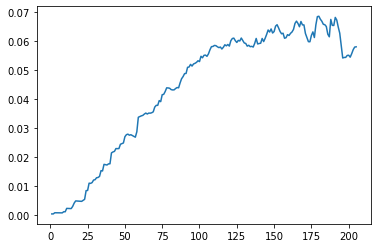

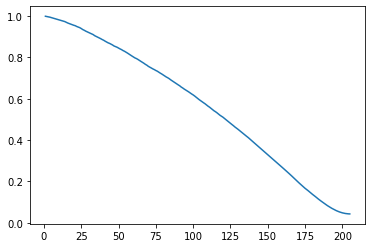

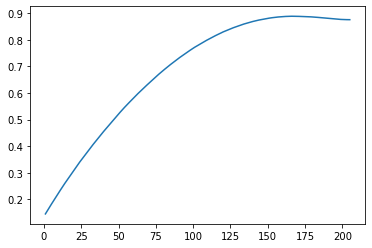

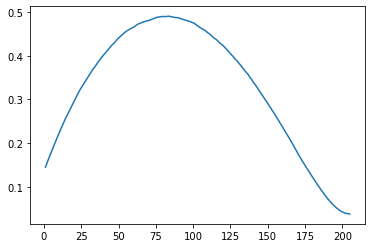

In [113]:
N = len(communities_gn)
mod = np.zeros(N)
cov = np.zeros(N)
perf = np.zeros(N)
for i in range(N):
    mod[i] = nx.algorithms.community.modularity(G,communities_gn[i])
    cov[i],perf[i] = nx.algorithms.community.partition_quality(G,communities_gn[i])
    #print('Girvan Newman optimization for %.d clusters:'%(i+1),mod[i])
x = [i+1 for i in range(N)]
plt.plot(x,mod)
plt.show()
plt.plot(x,cov)
plt.show()
plt.plot(x,perf)
plt.show()
plt.plot(x,cov*perf)

In [101]:
# label propagation
# According to this method there's just one community

communities_lp = nx.algorithms.community.label_propagation_communities(G)
communities_lp = list(communities_lp)
print(communities_lp)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205}]


In [102]:
len(communities_lp)

1

In [114]:
mod_mod = nx.algorithms.community.modularity(G,communities_modularity)
print('modularity optimization:',mod_mod)
mod_lp = nx.algorithms.community.modularity(G,communities_lp)
print('modularity label_propagation:',mod_lp)
mod_gn = nx.algorithms.community.modularity(G,communities_gn[0])
print('Girvan Newman optimization:',mod_gn)

modularity optimization: 0.265343862157711
modularity label_propagation: 0.0
Girvan Newman optimization: 0.0004002388410613495


In [115]:
qual_mod = nx.algorithms.community.partition_quality(G,communities_modularity)
print('Modularity (coverage,performance):',qual_mod)
qual_lp = nx.algorithms.community.partition_quality(G,communities_lp)
print('Label propagation (coverage,performance):',qual_lp)
qual_gn = nx.algorithms.community.partition_quality(G,communities_gn[0])
print('Girvan Newman (coverage,performance):',qual_gn)

Modularity (coverage,performance): (0.4736474694589878, 0.713379114373668)
Label propagation (coverage,performance): (1.0, 0.1356855316125977)
Girvan Newman (coverage,performance): (0.9986038394415357, 0.14501539190149182)


# __4. Plotting__